# Data Preprocessing
In this notebook the Weather Dataset is going to be pre-processed in order to have data that can be used by the graph neural network.

In [38]:
import pandas as pd

import torch
from torch_geometric.data import Data

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings


path_to_data = '../data/global-daily-climate-data/daily_weather.parquet'
if not(os.path.exists(path_to_data)): 
    raise FileNotFoundError(f'The file at path {path_to_data} does not exist.')

cities_nearby = ['Mersin', 'Latakia', 'Tartus', 'Tripoli', 'Hama', 'Nazareth', 'Tel Aviv', 
                 'Damascus', 'Heraklion', 'Athens', 'Damanhur']
cities_target = 'Larnaca'

In [39]:
dataframe = pd.read_parquet(path_to_data)
dataframe.head()

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN


For now only a few columns will be used. The rest will be dropped.

We also convert the season column to a winter, spring, summer and autumn columns, and set the date to be the index.
This will make it easier since we are interested in time-dependent events.

Moreover, we will create time-dependent columns that will be used to describe the day, week, month and year.

In [40]:
cols_to_drop = ['station_id', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh',
                'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa', 'sunshine_total_min']
dataframe = dataframe.drop(columns = cols_to_drop, axis = 1)
dataframe = dataframe.dropna()
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.set_index('date')

dataframe['day'] = dataframe.index.day
dataframe['week'] = dataframe.index.isocalendar().week
dataframe['month'] = dataframe.index.month
dataframe['quarter'] = dataframe.index.quarter
dataframe['year'] = dataframe.index.year


seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    dataframe[season.lower()] = (dataframe['season'] == season).astype(int)
dataframe = dataframe.drop(columns=['season'])
dataframe.head()

,city_name,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,day,week,month,quarter,year,winter,spring,summer,autumn
date,,,,,,,,,,,,,,
1957-07-01,Asadabad,27.0,21.1,35.6,0.0,1,27,7,3,1957,0,0,1,0
1957-07-02,Asadabad,22.8,18.9,32.2,0.0,2,27,7,3,1957,0,0,1,0
1957-07-03,Asadabad,24.3,16.7,35.6,1.0,3,27,7,3,1957,0,0,1,0
1957-07-04,Asadabad,26.6,16.1,37.8,4.1,4,27,7,3,1957,0,0,1,0
1957-07-05,Asadabad,30.8,20.0,41.7,0.0,5,27,7,3,1957,0,0,1,0


Now let's look at the correlation between these columns for the target city, Larnaca.

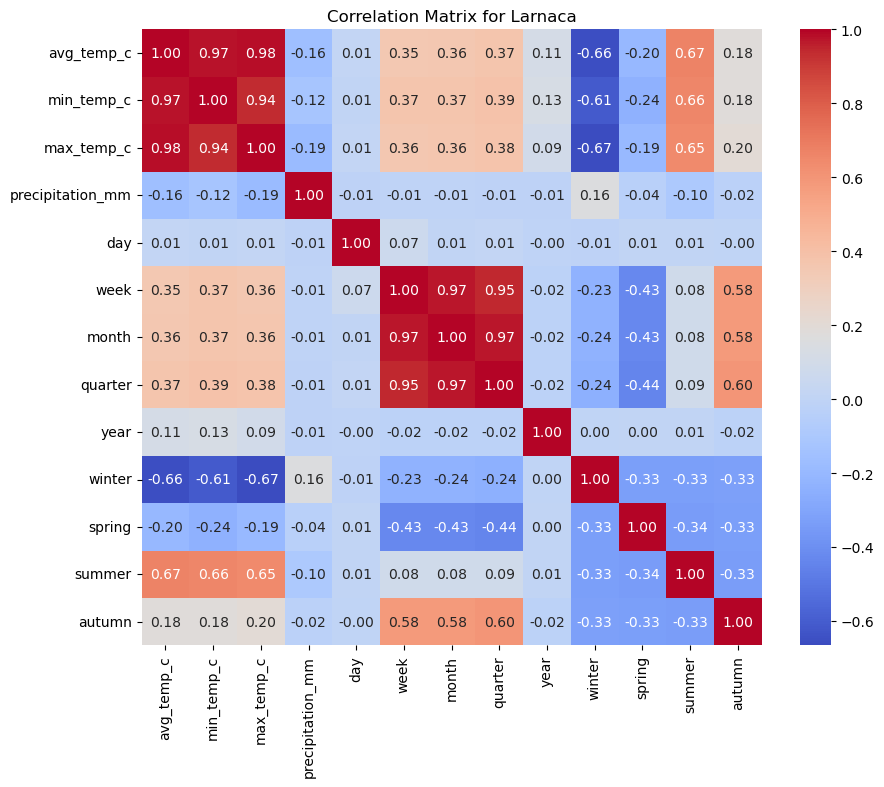

In [41]:
corr_matrix = dataframe[dataframe['city_name'] == cities_target].drop(columns = ['city_name']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title(f"Correlation Matrix for {cities_target}")
plt.show()

The three target variables, the `avg_temp_c`, `min_temp_c` and `max_temp_c` appear to show a significant correlation with time-dependent variables.

Before proceeding with the graph design, we must first normalize the data.
Since we are predicting the weather for Larnaca, we will remove it from the dataset, and normalize the rest. Subsequently, we can use the scaler to normalize new data.

In [42]:
scaler = MinMaxScaler()

filtered_cities = cities_nearby + [cities_target]
dataframe = dataframe[dataframe['city_name'].isin(filtered_cities)]
dataframe = dataframe.sort_index()

is_target = dataframe['city_name'] == cities_target
dataframe_norm = dataframe[~is_target]
dataframe_rest = dataframe[is_target]
columns_to_normalize = [col for col in dataframe_norm.columns if col not in ['city_name', 'winter', 'spring', 'summer', 'autumn']]

dataframe_not_norm = dataframe_norm.loc[:, ['city_name', 'winter', 'spring', 'summer', 'autumn']]
dataframe_norm = dataframe_norm.loc[:, columns_to_normalize]
dataframe_norm = pd.DataFrame(scaler.fit_transform(dataframe_norm.to_numpy()),
                              columns = columns_to_normalize, index = dataframe_norm.index)
dataframe_norm = pd.concat([dataframe_norm, dataframe_not_norm], axis = 1, ignore_index = False)
dataframe_norm.sort_index(ascending = True)

dataframe = pd.concat(
    [dataframe_rest.loc[:, dataframe.columns],
     dataframe_norm.loc[:, dataframe.columns]],
     axis = 0, ignore_index = False
     )
dataframe = dataframe.sort_index(ascending = True)
dataframe.tail(25)

,city_name,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,day,week,month,quarter,year,winter,spring,summer,autumn
date,,,,,,,,,,,,,,
2023-08-26,Damanhur,0.781407,0.883495,0.701493,0.000000,0.833333,0.634615,0.636364,0.666667,1.0,0,0,1,0
2023-08-26,Tartus,0.791457,0.907767,0.699360,0.000000,0.833333,0.634615,0.636364,0.666667,1.0,0,0,1,0
2023-08-26,Latakia,0.786432,0.910194,0.697228,0.000900,0.833333,0.634615,0.636364,0.666667,1.0,0,0,1,0
2023-08-27,Athens,0.811558,0.919903,0.742004,0.000000,0.866667,0.634615,0.636364,0.666667,1.0,0,0,1,0
2023-08-27,Damanhur,0.771357,0.868932,0.686567,0.000000,0.866667,0.634615,0.636364,0.666667,1.0,0,0,1,0
2023-08-27,Mersin,0.781407,0.900485,0.703625,0.000675,0.866667,0.634615,0.636364,0.666667,1.0,0,0,1,0
2023-08-27,Heraklion,0.751256,0.866505,0.652452,0.000000,0.866667,0.634615,0.636364,0.666667,1.0,0,0,1,0
2023-08-27,Latakia,0.773869,0.924757,0.678038,0.002812,0.866667,0.634615,0.636364,0.666667,1.0,0,0,1,0
2023-08-27,Tripoli,0.726131,0.764563,0.714286,0.000000,0.866667,0.634615,0.636364,0.666667,1.0,0,0,1,0


Notice that all nearby cities have normalized features apart from the target city.
Although this includes the temporal information, it will not affect the performance since we will obtain this information from a different city entry.

# Graph Design
The graphs that will be used for this project, will consist of nodes, each one representing one of the nearby cities. Each node will have a set of features, and additionally another set of features will represent the date of the prediction.
Each graph will represent a single day.

First, for simplicity, we will assume that, for a given day, we have measurements from nearby cities and we want to predict the average, minimum and maximum temperature in Larnaca.


In [ ]:
# the city coordinates will be used as edges to describe the graph
city_coordinates = {
    'Mersin': (36.8094, 34.6375),
    'Latakia': (35.5167, 35.7833),
    'Tartus': (34.8833, 35.8833),
    'Tripoli': (34.4333, 35.8333),
    'Hama': (35.1333, 36.7500),
    'Nazareth': (32.6996, 35.3035),
    'Tel Aviv': (32.0452, 34.7698),
    'Damascus': (33.5138, 36.2765),
    'Heraklion': (35.3387, 25.1442),
    'Athens': (37.9838, 23.7275),
    'Damanhur': (31.0406, 30.4699),
    'Larnaca': (34.9100, 33.6300)
}

# list to store all the graphs
graphs = []
for date in dataframe.index.unique():
    daily_data = dataframe.loc[[date]]
    
    # if Larnaca and at least one other city are present then we can create a graph
    cities_today = daily_data['city_name'].unique()
    if not ((cities_target in cities_today) and (len(cities_today) >= 2)):
        missing_cities = [city for city in filtered_cities if city not in cities_today]
        print(f'Skipping date {date}. Missing cities: ', end='')
        for city in missing_cities:
            print(city, ' ', end='')
        print()
        continue
    print(f'Creating graph for {date} with {len(cities_today)} cities.')

    # each city will be associated with one node of the graph with features about the daily weather forecast

    nodes = []
    node_names = []

    for i, city in enumerate(cities_today):
        city_data = daily_data[daily_data['city_name'] == city].iloc[0]

        node_features = torch.tensor([
            city_data['avg_temp_c'],
            city_data['min_temp_c'],
            city_data['max_temp_c'],
            city_data['precipitation_mm'],
            0, 0, 0, 0, 0  # Padding to make length 9
        ], dtype=torch.float)
    
        nodes.append(node_features)
        node_names.append(city)

    # we also need a temporal node for time information but not for the target
    # city since that one is not normalized.
    temporal_data = daily_data[daily_data['city_name'] != cities_target].iloc[0]

    node_features = torch.tensor([
        temporal_data['day'],
        temporal_data['week'],
        temporal_data['month'],
        temporal_data['quarter'],
        temporal_data['year'],
        temporal_data['winter'],
        temporal_data['spring'],
        temporal_data['summer'],
        temporal_data['autumn']
    ], dtype=torch.float)
    nodes.append(node_features)
    node_names.append('date')

    target_idx = node_names.index(cities_target)
    y = nodes[target_idx]

    # Create edges between cities based on latitude and longitude differences
    edges = []
    edge_features = []

    for i, city1 in enumerate(cities_today):
        for j, city2 in enumerate(cities_today):
            if i != j:
                lat_diff = city_coordinates[city1][0] - city_coordinates[city2][0]
                lon_diff = city_coordinates[city1][1] - city_coordinates[city2][1]
                edges.append((i, j))
                edge_features.append([lat_diff, lon_diff])

    # Connect all cities to the date node
    # For simplicity all cities are connected to the temporal node in the same way
    date_node_index = len(cities_today)
    for i in range(len(cities_today)):
        edges.append((i, date_node_index))
        edges.append((date_node_index, i))
        edge_features.append([1.0, 1.0])
        edge_features.append([1.0, 1.0])

    # Convert edges and edge features to tensors
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create the graph data object
    graph = Data(x = torch.stack(nodes), edge_index = edge_index, edge_attr = edge_attr, y = y)
    graph_data = {
        'graph': graph,
        'target_idx': target_idx
    }
    graphs.append(graph_data)

path_to_graphs = '../data/global-daily-climate-data/graphs.pt'
torch.save(graphs, path_to_graphs)

Skipping date 1957-01-07 00:00:00. Missing cities: Mersin  Latakia  Tartus  Tripoli  Hama  Nazareth  Tel Aviv  Damascus  Heraklion  Athens  Larnaca  
Skipping date 1957-01-13 00:00:00. Missing cities: Mersin  Latakia  Tartus  Tripoli  Hama  Nazareth  Tel Aviv  Damascus  Heraklion  Athens  Larnaca  
Skipping date 1957-04-10 00:00:00. Missing cities: Mersin  Latakia  Tartus  Tripoli  Hama  Nazareth  Tel Aviv  Damascus  Heraklion  Athens  Larnaca  
Skipping date 1957-06-09 00:00:00. Missing cities: Mersin  Latakia  Tartus  Tripoli  Hama  Nazareth  Tel Aviv  Damascus  Heraklion  Athens  Larnaca  
Skipping date 1957-06-22 00:00:00. Missing cities: Mersin  Latakia  Tartus  Tripoli  Hama  Nazareth  Tel Aviv  Damascus  Heraklion  Athens  Larnaca  
Skipping date 1957-06-30 00:00:00. Missing cities: Mersin  Latakia  Tartus  Tripoli  Hama  Nazareth  Tel Aviv  Damascus  Heraklion  Athens  Larnaca  
Skipping date 1957-07-01 00:00:00. Missing cities: Mersin  Latakia  Tartus  Tripoli  Hama  Nazareth 